In [51]:
# this needs to be run for each new runtime
# because colab has scikit-learn 1.0.2 pre-installed 
# and we need newer version (1.2.0 and higher)
# to use .set_output() method
# !pip install scikit-learn --upgrade

# if you plan on running the whole notebook again during the same runtime
# you can comment the line above

In [1]:
from sklearn import set_config

set_config(transform_output="pandas")

# Feature Selection

## 1.&nbsp; Dataset Creation

We will start by creating a dataset with many features. We will purposefully create a dataset with some good columns (columns that have a relationship with the label) and some bad columns (columns without any relationship whatsoever with the label) to illustrate how Feature Selection works. 

Bear in mind that the effectiveness of the feature selection methods depends largely on the dataset you're applying them to: if we were to have a dataset where ALL features have a meaningful relationship with the label, then dropping them would be counter-productive.

Having said that, you do not need to understand (or look into) how we create the dataset.

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_regression

In [52]:
# Create a dataset with many features. Go right to the output of this code.

np.random.seed(123)
scale_values = np.logspace(1, 10, num=25)

X, y = make_regression(n_samples=1000, 
                       n_features=25, 
                       n_informative=6,
                       effective_rank=4,
                       noise=0.2,
                       random_state=42)

X = pd.DataFrame(X)
y = pd.DataFrame(y)
X["25"] = np.random.normal(scale=1.1, loc=0.01, size = len(X))
X["26"] = np.random.normal(scale=4, loc=1, size = len(X))
X["27"] = 1.
X["28"] = 0.
X["29"] = np.concatenate([np.zeros(len(X)-1), [0.1]])
X["30"] = X.iloc[:,3] * 0.823
X["31"] = X.iloc[:,8] * np.random.normal(scale=0.3, loc=1, size = len(X))

X = X.add_prefix("feature_")
y.rename(columns={0:"label"}, inplace=True)

codealong_df = pd.concat([X, y], axis=1)
codealong_df

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,label
0,-0.018296,-0.001839,0.016016,-0.019307,0.001856,0.027113,0.013745,0.000633,0.017954,-0.009104,...,0.017348,-0.011803,-1.184194,-1.995310,1.0,0.0,0.0,-0.015890,0.008398,-0.076775
1,0.001363,-0.034291,-0.001782,-0.001157,-0.000928,0.021803,-0.017609,0.001054,0.000947,-0.016167,...,-0.023567,0.020733,1.107080,3.270379,1.0,0.0,0.0,-0.000952,0.000606,1.945816
2,-0.007991,0.013612,0.008775,-0.004530,0.002792,0.009852,0.004221,0.002174,-0.007749,0.016543,...,-0.005296,-0.006772,0.321276,3.872602,1.0,0.0,0.0,-0.003728,-0.010298,1.261298
3,-0.012161,0.021575,-0.008932,-0.007190,-0.010184,-0.016184,0.001812,-0.008250,-0.008352,-0.009462,...,-0.001067,0.006821,-1.646924,-2.997523,1.0,0.0,0.0,-0.005918,-0.010509,-4.510620
4,-0.029442,-0.005390,0.011258,0.024444,0.013054,-0.012449,-0.026195,0.025240,0.007042,-0.005765,...,-0.022302,0.011463,-0.626460,2.899593,1.0,0.0,0.0,0.020117,0.003830,3.017716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.004784,-0.005852,0.003786,-0.018332,0.017759,-0.011987,-0.019495,0.006243,0.014125,-0.007231,...,-0.017950,0.018817,0.708239,4.382805,1.0,0.0,0.0,-0.015087,0.013806,2.110393
996,0.029737,0.009150,0.011322,0.026551,0.007310,0.003309,-0.007107,0.021561,0.021082,0.020325,...,0.005461,-0.018409,1.186910,-3.479690,1.0,0.0,0.0,0.021852,0.015098,0.666808
997,0.009199,0.012291,0.021928,0.021705,-0.006578,-0.036746,-0.037261,-0.009584,0.019986,0.008848,...,-0.027405,0.007829,-0.990260,-0.437187,1.0,0.0,0.0,0.017864,0.032221,-1.141679
998,-0.002704,-0.011813,-0.002855,0.019239,0.000741,0.017812,-0.010176,0.000241,-0.010978,-0.002322,...,0.022012,-0.015817,0.527290,-5.438780,1.0,0.0,0.0,0.015834,-0.014323,-2.718885


## 2.&nbsp; Train - test split

Like always in ML, we split the data in train set and test set.

As you already know, it is very important that we perform all transformations considering only the train set —only later we will apply those transformations on the test set.

In feature selection, this will mean that we will decide which columns are useful / useless only by looking at the train set. Once identified which columns to drop, we will also drop those very same columns from the test set.

When using Scikit-Learn transformers, that means we will be calling the `fit()` method only to the train set, and the `transform()` method to both the train and the test. If we do feature selection without Scikit-Learn, we will need to make sure our custom code respects this approach.

In [5]:
from sklearn.model_selection import train_test_split

In [53]:
X = codealong_df.drop(columns="label")
y = codealong_df["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## 3.&nbsp; Quick baseline models (baseline for performance)

For simplicity, we will not be tuning the model parameters in this codealong. Feel free to do so on your own. We will only be tracking and comparing the performance of a Decision Tree with default parameters and a K-Nearest Neighbors with K=1, running them after each new feature selection strategy.

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

In [54]:
# Initialize and fit a Decision Tree.
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Initialize and fit K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=1)

Remember that the objective of feature selection is not only to improve model performance. Achieving a simple, lean solution that prevents us from unnecessary complexities (including the risk of overfitting) and reducing training time are arguably more important reasons to do feature selection. But it's still always a good idea to look at the performance!

We will check the $R^2$ of the models. Usually, it is recommended to not only rely on a single metric to measure performance. Other metrics such as MAE or RMSE can be checked as well, feel free to do so.

In [55]:
from sklearn.metrics import r2_score

In [57]:
# Make predictions using the Decision Tree and K-Nearest Neighbors.
tree_pred = tree.predict(X = X_test)
knn_pred = neigh.predict(X = X_test)

Create a DataFrame to track the performance of the different models we will create.

In [58]:
performances = pd.DataFrame(columns=["performance_tree", "performance_knn"])

In [59]:
# Add the first performances of the baseline models to the DataFrame.
performances.loc["baseline", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["baseline", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195


You can already see how a Decision Tree handles a noisy dataset much better than K-Nearest Neighbors. In a Decision Tree, only the "best" features take part in the algorithm, whereas in a K-Nearest Neighbors, all features matter the same. It does not mean that the Decision Tree will always be the better algorithm: after preprocessing, it's possible that the K-Nearest Neighbors works better.

## 4.&nbsp; Variance Threshold

This is the first feature selection method we will use.

Features with a low variance have a low amount of information. With this transformer, we can drop the features with the lowest variance. We will set a threshold and all features with a variance below that number will be dropped. 

Notice first that the variance of a column also depends on its scale. In our dataset, most of the columns have a really small range, except for features 25 and 26.

In [60]:
# Use .describe() to get the min and max values for each feature.
# Transpose for better legibility.
X.describe().loc[["min", "max"]].T

,min,max
feature_0,-0.051263,0.065259
feature_1,-0.049275,0.054823
feature_2,-0.041521,0.038658
feature_3,-0.060214,0.055822
feature_4,-0.044809,0.039780
feature_5,-0.058884,0.054911
feature_6,-0.057240,0.042720
feature_7,-0.055675,0.049252
feature_8,-0.052158,0.049647
feature_9,-0.065688,0.058079


The small range shows when we look at the variance of the features. Since the list is sorted, the features with the largest variance are shown at the bottom of the list.

In [62]:
# Calculate the variance for each feature.
X.var().sort_values()

feature_28     0.000000
feature_27     0.000000
feature_29     0.000010
feature_2      0.000133
feature_4      0.000134
feature_21     0.000145
feature_16     0.000178
feature_12     0.000194
feature_30     0.000198
feature_10     0.000206
feature_24     0.000206
feature_6      0.000222
feature_15     0.000224
feature_8      0.000231
feature_19     0.000233
feature_9      0.000242
feature_1      0.000249
feature_22     0.000252
feature_31     0.000258
feature_18     0.000263
feature_17     0.000278
feature_20     0.000280
feature_3      0.000292
feature_0      0.000293
feature_7      0.000307
feature_23     0.000312
feature_11     0.000321
feature_5      0.000351
feature_14     0.000369
feature_13     0.000420
feature_25     1.213120
feature_26    14.699216
dtype: float64

### 4.1. Data Scaling
As we just saw, the large variance of columns 25 and 26 might be due to the fact that their values cover a bigger range. This means though that their variances cannot be compared well with those of the other columns.

Therefore, it's a good idea to scale the features before removing those with the smallest variance.

Some scaling processes (e.g. standardization) transform features in such a way that they all end up having the same variance. This is **not** what we want! It is important to pick a scaler that does not do that. We will use min-max scaling.

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
# Initialize the scaler.
my_scaler = MinMaxScaler()

# Fit the scaler to X_train and transform the values.
X_train_scaled = my_scaler.fit_transform(X_train)

# Create a DataFrame.
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31
512,0.614009,0.733123,0.770169,0.606915,0.616808,0.320759,0.445420,0.797849,0.803889,0.382003,...,0.266014,0.507584,0.629871,0.756519,0.646566,0.0,0.0,0.0,0.606915,0.964515
685,0.369810,0.427530,0.402222,0.351732,0.457979,0.400635,0.777078,0.717130,0.643384,0.634979,...,0.605778,0.641613,0.408419,0.512607,0.887287,0.0,0.0,0.0,0.351732,0.655263
997,0.518891,0.591420,0.791336,0.690254,0.451952,0.197586,0.199863,0.439269,0.703922,0.602223,...,0.602784,0.275470,0.588566,0.335042,0.541440,0.0,0.0,0.0,0.690254,0.860576
927,0.337817,0.305676,0.600526,0.398417,0.435403,0.445649,0.394704,0.416403,0.528816,0.408013,...,0.430963,0.832858,0.313288,0.506681,0.741573,0.0,0.0,0.0,0.398417,0.546256
376,0.558754,0.384005,0.485449,0.390344,0.575478,0.880489,0.543484,0.753531,0.440628,0.539449,...,0.558473,0.476339,0.757301,0.398884,0.684040,0.0,0.0,0.0,0.390344,0.435150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,0.381848,0.310594,0.499361,0.597522,0.273754,0.629923,0.510986,0.544987,0.401220,0.619136,...,0.706038,0.458329,0.414016,0.204868,0.524097,0.0,0.0,0.0,0.597522,0.423169
322,0.560378,0.543700,0.596321,0.472220,0.542789,0.452386,0.592453,0.443633,0.449202,0.677678,...,0.477096,0.768168,0.269238,0.414224,0.656894,0.0,0.0,0.0,0.472220,0.497887
382,0.425607,0.415240,0.478694,0.701738,0.403586,0.708194,0.623055,0.602669,0.449071,0.699894,...,0.679583,0.979780,0.457231,0.276209,0.515200,0.0,0.0,0.0,0.701738,0.483548
365,0.402321,0.364662,0.778379,0.876065,0.569403,0.596454,0.591172,0.503578,0.477991,0.544147,...,0.561387,0.327087,0.599492,0.478783,0.458106,0.0,0.0,0.0,0.876065,0.513487


In [63]:
# Calculate the variance for all features and sort descending.
X_train_scaled.var().sort_values()

feature_28    0.000000
feature_27    0.000000
feature_29    0.001250
feature_9     0.015667
feature_22    0.016657
feature_4     0.018682
feature_13    0.019783
feature_2     0.021117
feature_0     0.021403
feature_12    0.021515
feature_6     0.021541
feature_8     0.021795
feature_25    0.021967
feature_1     0.022678
feature_26    0.022800
feature_11    0.023020
feature_14    0.023279
feature_21    0.023905
feature_23    0.025554
feature_20    0.025556
feature_31    0.025653
feature_30    0.026132
feature_3     0.026132
feature_10    0.026331
feature_5     0.027207
feature_17    0.027359
feature_7     0.027464
feature_16    0.028807
feature_24    0.029206
feature_15    0.029412
feature_19    0.029589
feature_18    0.031955
dtype: float64

As you can see, after scaling, features 25 and 26 are no longer the ones with the largest variances. We can now apply the `VarianceThreshold` transformation.

In [64]:
from sklearn.feature_selection import VarianceThreshold

In [66]:
# Initialize the feature selector with a threshold of 0.02.
# All features with a smaller variance will be deleted from the dataset.
selector = VarianceThreshold(threshold=0.02)
X_train_threshold = selector.fit_transform(X_train_scaled)

Let's check how many features were dropped:

In [67]:
print("shape before:", X_train_scaled.shape)
print("shape after:", X_train_threshold.shape)

shape before: (800, 32)
shape after: (800, 25)


It looks like we dropped `7` features with a threshold of `0.02`. Feel free to increase or decrease the threshold if you want to drop more or less features. 

**Note:** In general, it is not recommended to drop many features with this transformer. This is because a feature could have a small amount of information that is VERY important for whatever we want to predict.

Example: A feature in the Housing dataset with the number of "Private Helicopters" would have a small variance since we expect almost all houses to have `0` helicopters. But if a house has one, it very likely increases the price substantially. Therefore, it could still be important to keep this information.

When in doubt, only drop features with zero variance: those have really zero information, and dropping them will always be the right approach.

Let's recover the feature names after having dropped the low variance features.

In [69]:
X_train_threshold

,feature_0,feature_1,feature_2,feature_3,feature_5,feature_6,feature_7,feature_8,feature_10,feature_11,...,feature_18,feature_19,feature_20,feature_21,feature_23,feature_24,feature_25,feature_26,feature_30,feature_31
512,0.614009,0.733123,0.770169,0.606915,0.320759,0.445420,0.797849,0.803889,0.249004,0.483621,...,0.831885,0.257105,0.206392,0.385642,0.507584,0.629871,0.756519,0.646566,0.606915,0.964515
685,0.369810,0.427530,0.402222,0.351732,0.400635,0.777078,0.717130,0.643384,0.378265,0.542098,...,0.491528,0.446408,0.331202,0.262333,0.641613,0.408419,0.512607,0.887287,0.351732,0.655263
997,0.518891,0.591420,0.791336,0.690254,0.197586,0.199863,0.439269,0.703922,0.793050,0.693162,...,0.860602,0.000000,0.723935,0.603982,0.275470,0.588566,0.335042,0.541440,0.690254,0.860576
927,0.337817,0.305676,0.600526,0.398417,0.445649,0.394704,0.416403,0.528816,0.596992,0.735277,...,0.411106,0.569353,0.559308,0.526014,0.832858,0.313288,0.506681,0.741573,0.398417,0.546256
376,0.558754,0.384005,0.485449,0.390344,0.880489,0.543484,0.753531,0.440628,0.357169,0.307120,...,0.217879,0.800877,0.651838,0.489999,0.476339,0.757301,0.398884,0.684040,0.390344,0.435150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,0.381848,0.310594,0.499361,0.597522,0.629923,0.510986,0.544987,0.401220,0.277215,0.595437,...,0.537497,0.590119,0.471285,0.607647,0.458329,0.414016,0.204868,0.524097,0.597522,0.423169
322,0.560378,0.543700,0.596321,0.472220,0.452386,0.592453,0.443633,0.449202,0.674011,0.549189,...,0.703811,0.722135,0.423322,0.437838,0.768168,0.269238,0.414224,0.656894,0.472220,0.497887
382,0.425607,0.415240,0.478694,0.701738,0.708194,0.623055,0.602669,0.449071,0.467269,0.440219,...,0.395173,0.633249,0.670382,0.483375,0.979780,0.457231,0.276209,0.515200,0.701738,0.483548
365,0.402321,0.364662,0.778379,0.876065,0.596454,0.591172,0.503578,0.477991,0.620809,0.386005,...,0.685337,0.571103,0.793466,0.698246,0.327087,0.599492,0.478783,0.458106,0.876065,0.513487


As the next step, transform the test set. Always remember to use the `transform` method on the test dataset and not the `fit_transorm`, which we reserve for the train set.

In [70]:
# Transform the test dataset using the scaler.
X_test_scaled = my_scaler.transform(X_test)

# Apply the variance threshold to the scaled dataset.
X_test_threshold = selector.transform(X_test_scaled)

Let's check how well our model performs with the new dataset.

In [72]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_threshold, y_train)
tree_pred = tree.predict(X = X_test_threshold)

# K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train_threshold, y_train)
knn_pred = neigh.predict(X = X_test_threshold)

performances.loc["varThreshold", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["varThreshold", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197


While the performance of our K-Nearest Neighbors model increased, our Decision Tree model performs much worse now. This suggests that there was some useful information in the columns we just dropped. This is not uncommon to happen when using the variance threshold.

Let's use it again, but with a more conservative threshold to see whether this makes a difference.

### 4.2. Variance scaling: 2nd iteration

In [73]:
# Set the threshold to 0, i.e. remove only columns with zero variance.
selector2 = VarianceThreshold(threshold=0)
X_train_threshold2 = selector2.fit_transform(X_train_scaled)

print("shape before:", X_train_scaled.shape)
print("shape after:", X_train_threshold2.shape)

shape before: (800, 32)
shape after: (800, 30)


We have only dropped 2 features that had zero variance. Let's see how this impacts performance.

Remember to always transform your test set the same way you transformed your train set:

In [74]:
X_test_threshold2 = selector2.transform(X_test_scaled)

In [75]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_threshold2, y_train)
tree_pred = tree.predict(X = X_test_threshold2)

# K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train_threshold2, y_train)
knn_pred = neigh.predict(X = X_test_threshold2)

performances.loc["varThreshold_2", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["varThreshold_2", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197
varThreshold_2,0.8102,0.338966


## 5.&nbsp; Collinearity

Features that have a perfect (or extremely high) correlation with each other can be considered to be the same feature. We want to drop one of them. Let's first explore the pairwise correlations between all features.

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

As a first step, let's drop the two columns with zero variance, i.e. those containing only a single, constant value. These columns would otherwise introduce bias into the correlation matrix.

In [79]:
# Comment out the code below to get the correlation matrix with and without the constant features.
X_train.drop(columns=["feature_27", "feature_28"], inplace=True)
X_test.drop(columns=["feature_27", "feature_28"], inplace=True)

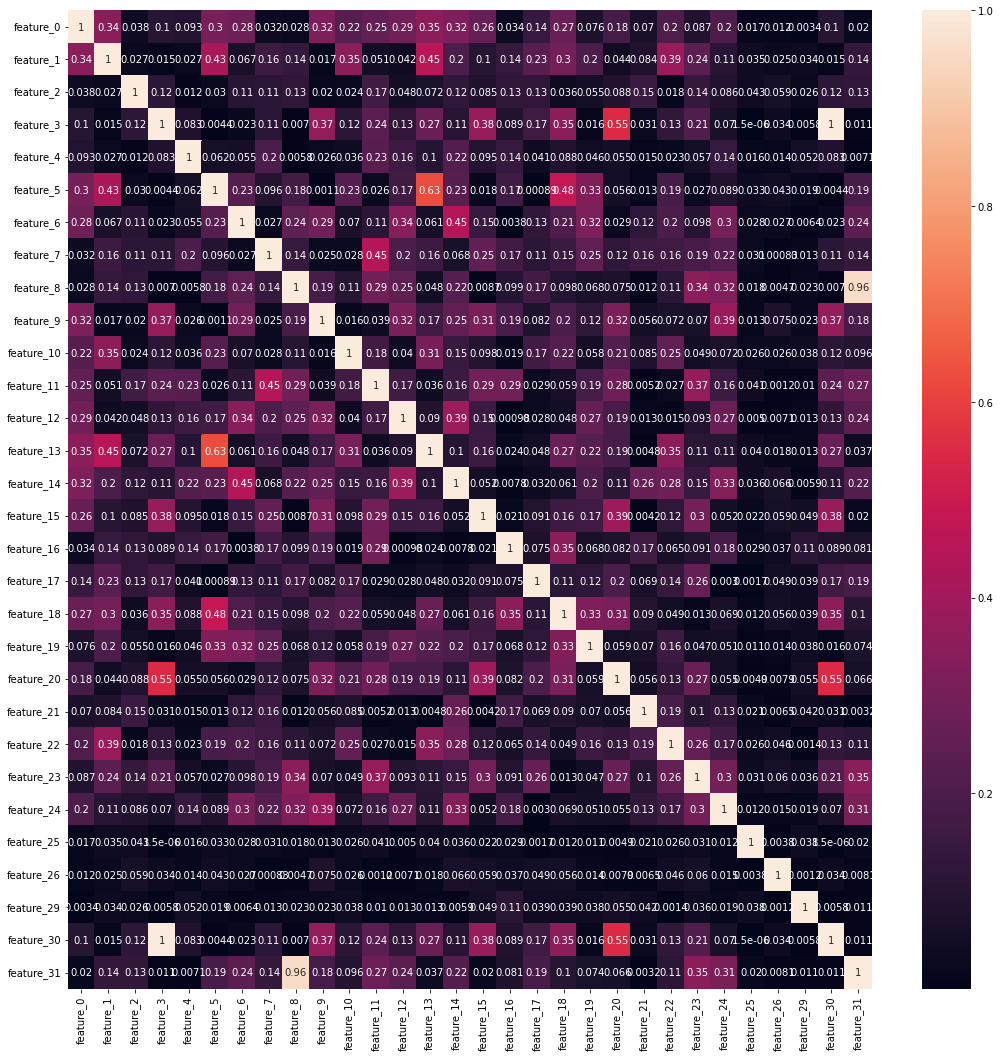

In [80]:
# Create the correlation matrix, using the absolute values.
# For our purpose, it doesn't matter whether the correlation is positive or negative.
corrMatrix = X_train.corr().abs()

# Plot a heatmap of the correlation matrix.
fig, ax = plt.subplots(figsize=(18,18))
sns.heatmap(corrMatrix, annot=True);

We can see how there is a pair of columns with a _perfect_  correlation (`1`) and another pair of columns with a very high correlation (`0.96`). The rest of the correlation coefficients are much smaller and can be neglected at this stage.

We will now write code that identifies pairs of columns with a correlation coefficient above a certain threshold (defined by us) and drops one of them. Also, we will drop one of the two highly correlated columns arbitrarily. As an alternative, it is very well possible to go for a slightly more sophisticated approach and e.g. keep the column that has the higher correlation with the target. Keeping the mean would also be a viable option.

In [81]:
# Select the upper triangle of the correlation matrix.
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(bool))

upper

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_29,feature_30,feature_31
feature_0,NaN,0.344833,0.037537,0.101798,0.092975,0.302406,0.279859,0.032449,0.028064,0.317043,...,0.180848,0.069641,0.203780,0.086980,0.202720,0.017362,0.011982,0.003435,0.101798,0.020437
feature_1,NaN,NaN,0.027445,0.015153,0.026652,0.425335,0.066512,0.160164,0.138719,0.017006,...,0.043616,0.083506,0.386402,0.237522,0.108058,0.035264,0.024792,0.034373,0.015153,0.135249
feature_2,NaN,NaN,NaN,0.120080,0.011675,0.030450,0.108210,0.109508,0.127813,0.020361,...,0.088312,0.153482,0.018233,0.136980,0.086062,0.042728,0.059334,0.026372,0.120080,0.129466
feature_3,NaN,NaN,NaN,NaN,0.083497,0.004435,0.023340,0.111157,0.007025,0.372385,...,0.548399,0.031056,0.129513,0.209715,0.070165,0.000002,0.033880,0.005815,1.000000,0.010754
feature_4,NaN,NaN,NaN,NaN,NaN,0.061849,0.054947,0.202363,0.005779,0.026286,...,0.054764,0.015381,0.023217,0.057490,0.143728,0.016173,0.013768,0.052295,0.083497,0.007074
feature_5,NaN,NaN,NaN,NaN,NaN,NaN,0.225988,0.096298,0.177543,0.001102,...,0.056119,0.012964,0.186201,0.027058,0.089395,0.033086,0.043265,0.019391,0.004435,0.185852
feature_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026789,0.242925,0.285268,...,0.028593,0.123845,0.197280,0.098082,0.301947,0.027734,0.026549,0.006418,0.023340,0.240777
feature_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.142166,0.025053,...,0.123073,0.164019,0.164926,0.189544,0.220493,0.030624,0.000830,0.013001,0.111157,0.137055
feature_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.191122,...,0.074842,0.011622,0.109928,0.343957,0.321605,0.018204,0.004746,0.022860,0.007025,0.960756
feature_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.316044,0.056141,0.072406,0.069798,0.386700,0.012714,0.075489,0.023399,0.372385,0.183422


In [82]:
# Find the index of those feature columns with correlation greater than 0.95.
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['feature_30', 'feature_31']

Once we have identified which columns to drop, we drop them from both the train and the test set. All this custom code can be rewritten as a function. The function can then be converted into a Scikit-Learn transformer with [Function Transformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html). That would allow you to include such a transformer in a Scikit-Learn Pipeline.

In [83]:
# Drop the columns from the train set.
X_train_selected = X_train.drop(columns=to_drop)

# Drop the columns from the test set.
X_test_selected = X_test.drop(columns=to_drop)

Let's check the performance again:

In [84]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_selected, y_train)
tree_pred = tree.predict(X = X_test_selected)

# K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train_selected, y_train)
knn_pred = neigh.predict(X = X_test_selected)

performances.loc["collinearity", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["collinearity", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197
varThreshold_2,0.8102,0.338966
collinearity,0.793828,-0.987643


We still haven't achieved a performance increase!

The methods we've tried so far are simple and a must-know in the fundamentals of Machine Learning. But, in practice, there are more powerful methods provided by the Scikit-Learn library. Initially, they might feel like a "black-box", difficult to interpret, but they are just applying basic statistical tests and/or ML models, and iterating different combinations of features and storing the results every time.

## 6.&nbsp;K Best

You can use statistical tests such as ANOVA or chi2 to rank features, and keep the selected best ones. For these kind of Scikit-Learn methods, it's important to look at [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) and, if possible to the [user guide](https://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection). Always try to understand the parameters and look at the examples given in the user guide. If you find the documentation too difficult to follow, google for tutorials.

In [85]:
from sklearn.feature_selection import SelectKBest, f_regression

The chosen statistical test has to be adequate for the data type you're dealing with. In our case, since we have a regression problem, we will choose an f-test. Check out [Ben Lambert's Youtube channel](https://www.youtube.com/watch?v=ie-MYQp1Nic&ab_channel=BenLambert) for detailed explanations and examples on the f-test.

In short, Scikit-Learn makes many univariate linear models (one for each feature) and computes the f-statistic for each one of them. The f-statistic measures the ability of a linear model with each of the single features to make better predictions compared to using only the intercept. This creates a "score" of each feature's predictability value, which we can use to rank the features.

For the sake of understanding better how `SelectKBest` works, let's run the raw statistical test and have a look at the f-statistics (and corresponding p-values) of each feature:

In [86]:
# Run the univariate (= one feature at a time) linear regression tests.
f_stat, p_val = f_regression(X_train, y_train)

# Create a DataFrame with the f-statistics and p-values.
f_test = pd.DataFrame({"f_stat":f_stat, 
                       "p_val":p_val}, 
                      index=X_train.columns)

# Sort the values in the f-statistic column.
f_test.sort_values("f_stat", ascending=False)

,f_stat,p_val
feature_16,613.642293,6.166204e-101
feature_17,574.378182,4.856182e-96
feature_4,317.693750,4.476269e-60
feature_18,77.020510,1.016093e-17
feature_11,60.709343,2.059481e-14
feature_7,53.810295,5.434696e-13
feature_1,42.225456,1.431242e-10
feature_23,29.215578,8.557706e-08
feature_31,19.905804,9.303760e-06
feature_20,18.498722,1.910863e-05


What we can see above is a ranking of the "best" features, measured by their ability to predict the label on their own in a linear model. The `SelectKBest` transformer runs this test under the hood, and gives you acces to a parameter `K` to directly select how many of the "top" features do you want to keep. We will start with `K=10`. Feel free to change this value.

> In a pipeline with `GridSearchCV`, you can finetune the `K` parameter by trying out many possible values, in combination with other preprocessing and modelling parameters. In general, in Machine Learning, all parameters are found through some sort of automated search or optimization technique — you can have a good intuition as you gain experience, but should never feel you have to just "know" the right value for a parameter.

In [88]:
# Initialize KBest, using the f-regression and setting k=10.
KBest = SelectKBest(score_func=f_regression, k=10)

As always, after initializing the transformer we fit it to the train set and transform both the train and the test set:

In [89]:
# Transform the train set.
X_train_KBest = KBest.fit_transform(X_train, y_train)

# Transform the test set.
X_test_KBest = KBest.transform(X_test)

Now, you can see how both the train and the test set have only 10 features.

In [38]:
print(X_train_KBest.shape, X_test_KBest.shape)

(800, 10) (200, 10)


Let's see how our models perform with these 10 "best" features:

In [90]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_KBest, y_train)
tree_pred = tree.predict(X = X_test_KBest)

# K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train_KBest, y_train)
knn_pred = neigh.predict(X = X_test_KBest)

performances.loc["KBest", "performance_tree"]= r2_score(y_test, tree_pred)
performances.loc["KBest", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197
varThreshold_2,0.8102,0.338966
collinearity,0.793828,-0.987643
KBest,0.836543,0.606619


The performance of both models has increased significantly! It's possible it would increase even more by tuning the value of `K`.

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

KBest = SelectKBest(score_func=f_regression, k=10)
tree = DecisionTreeRegressor()

pipe = make_pipeline(
    (KBest),
    (tree)
)
pipe

Pipeline(steps=[('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x7f237e4524c0>)),
                ('decisiontreeregressor', DecisionTreeRegressor())])

In [96]:
param_grid = {
    'selectkbest__k':range(5,15)
}
grid_search = GridSearchCV(
    pipe,
    param_grid = param_grid,
    cv=5,
    scoring='r2',
    verbose =1

)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x7f237e4524c0>)),
                                       ('decisiontreeregressor',
                                        DecisionTreeRegressor())]),
             param_grid={'selectkbest__k': range(5, 15)}, scoring='r2',
             verbose=1)

In [97]:
grid_search.best_params_

{'selectkbest__k': 5}

In [98]:
r2_score(y_test,grid_search.predict(X_test))

0.8307524776613268

## 7.&nbsp; Recursive Feature Elimination (RFE)

As always, check the documentation (and the user guide): https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html

RFE starts by taking all the features, training a model of our choice and storing its performance.

The chosen model must be capable of computing something called "feature importances" (i.e. a scoring that ranks features by its predictive value). Tree-based models can do that, but the KNN, for example, can not.

In practice, it returns something similar to the `SelectKBest`: a list with the features ranked from best to worst. Let's check out this list before we move forward.

In [99]:
# Decision tree
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

# Get the importance of each feature.
feature_importances = tree.feature_importances_
column_names = X_train.columns

In [102]:


# Create a DataFrame with the feature names and their importances.
feat_imp = pd.DataFrame({"feature":column_names,
                         "importance":feature_importances})

# Sort the values in the importance column.
feat_imp.sort_values("importance", ascending=False)

,feature,importance
17,feature_17,0.409243
16,feature_16,0.340444
4,feature_4,0.188138
2,feature_2,0.008058
19,feature_19,0.007288
12,feature_12,0.005728
22,feature_22,0.005220
1,feature_1,0.003800
26,feature_26,0.003779
7,feature_7,0.002954


Then, RFE drops the worst feature, trains the model again and compares the achived performance to the previous one. If the performance stays the same or improves, it keeps dropping features, one at a time. Once the performance drops, it stops and saves that model. 

With this approach, you don't have to define manually (or fine-tune) how many features to keep: it is decided by the method itself.

Note that with RFE, feature selection and model training happens in a single step. From the surface, you will not even see how many features are dropped: you will directly obtain a model capable of making predictions. Under the hood, some features have been dropped and have not been included in the model.

In [103]:
from sklearn.feature_selection import RFECV

In [104]:
# Decision Tree.
RFE_selector_tree = RFECV(DecisionTreeRegressor())
RFE_selector_tree.fit(X_train, y_train)
tree_pred = RFE_selector_tree.predict(X = X_test)

performances.loc["RFE", "performance_tree"] = r2_score(y_test, tree_pred)

performances

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:413: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197
varThreshold_2,0.8102,0.338966
collinearity,0.793828,-0.987643
KBest,0.836543,0.606619
RFE,0.871046,NaN


In [106]:
RFE_selector_tree.get_feature_names_out()

array(['feature_4', 'feature_16', 'feature_17'], dtype=object)

The performance has increased again!

We can extract the names of the features picked by RFE from the `RFE_selector_tree` object:

In [107]:
RFE_selector_tree.get_feature_names_out()

array(['feature_4', 'feature_16', 'feature_17'], dtype=object)

It looks like only three features were kept! They match the 3 "best" features from `SelectKBest`, which makes a lot of sense: with proper tuning of the `K` parameter, the two methods would have eventually converged. However, this might not always be the case: RFE has the ability to check how multiple features operate in combination with each other, while SelectKBest does univariate selection (checks features individually with the target). RFE might be able to detect valuable non-linear interactions between several features.

> A quick note about `get_feature_names_out()`: when you see methods like this one in a pre-made notebook, it might seem like you just "had to know" them. But that's not true! What you have to know is that Scikit-Learn transformer objects tend to keep valuable information in them after they were fitted. If you want to get this information, always look in the documentation for available attributes and methods, and scan for whatever you need. In this case, googling "which features are selected in SelectKBest" would also give good results.



## 8.&nbsp; Select from model

In similar fashion to RFE, [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html?highlight=selectfrommodel#sklearn.feature_selection.SelectFromModel) also checks for different feature combinations while training a model capable of scoring feature importances.

The difference is that `SelectFromModel` outputs the transformed dataset after dropping the features instead of the trained model. This will allow you to use this transfomer with a particular model (e.g. a Decision Tree) just for feature selection, but then try other models (e.g. a KNN) in your pipeline.

In `SelectFromModel` you can also play with the `threshold` parameter to keep a higher or lower number of features. This parameter is different from the `K` in `SelectKBest` in that you don't pass it the number of features to keep, but the lowest score a feature must have (in the "feature importances" ranking) to be included. Since these scores are abstract, it is difficult to come up with the right number without previous exploration or tuning. Here, for simplicity, we will leave it with its defalut, `None`, and let Scikit-Learn's built-in rules do the job.

In [44]:
from sklearn.feature_selection import SelectFromModel

In [45]:
# Initialize the transfomer.
select_model_tree = SelectFromModel(DecisionTreeRegressor(), 
                                    threshold=None)

In [108]:
# Transform the train set.
X_train_selected_model_tree = select_model_tree.fit_transform(X_train, y_train)

# Transform the test set.
X_test_selected_model_tree = select_model_tree.transform(X_test)

In [109]:
# Show shape of the train and test dataset to check for the number of features kept.
print(X_train_selected_model_tree.shape, X_test_selected_model_tree.shape)

(800, 3) (200, 3)


Again, only three features were kept. When different methods converge towards the same output, we can be confident it's a good one.

In [110]:
select_model_tree.get_feature_names_out()

array(['feature_4', 'feature_16', 'feature_17'], dtype=object)

We can now try how both the Decision Tree and the KNN perform with these three features:

In [111]:
# Decision tree.
tree = DecisionTreeRegressor()
tree.fit(X_train_selected_model_tree, y_train)
tree_pred = tree.predict(X = X_test_selected_model_tree)

# K-Nearest Neighbors.
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(X_train_selected_model_tree, y_train)
knn_pred = neigh.predict(X = X_test_selected_model_tree)

performances.loc["model_selected", "performance_tree"] = r2_score(y_test, tree_pred)
performances.loc["model_selected", "performance_knn"] = r2_score(y_test, knn_pred)

performances

,performance_tree,performance_knn
baseline,0.810648,-1.010195
varThreshold,0.598188,0.180197
varThreshold_2,0.8102,0.338966
collinearity,0.793828,-0.987643
KBest,0.836543,0.606619
RFE,0.871046,NaN
model_selected,0.873072,0.922235


Maybe you had lost faith in it but... the KNN model seems to have suddenly taken off with this combination of features! Let this be a lesson on how algorithms react differently to the same preprocessing / feature selection strategy.

## 9.&nbsp;Challenge

Apply feature selection to your Housing Regression Pipeline. You don't have to apply ALL the methods we have shown here: a single one is enough. We recommend doing some experimentation with 2-3 methods and finally settling for a single one.

Research on your own to find out how to **include feature selection into your Scikit-Learn pipeline** and even tune it with GridSearchCV. It's not mandatory, but it will make your ML workflow more cohesive.

In [50]:
# good luck!